# Week 1 - 5

In [8]:
# WEEK 1 - Project Setup
from pathlib import Path

# Define root as the project root (adjust if running from different dir)
ROOT = Path.cwd().parent  

# --- Create folder structure ---
dirs = [
    ROOT / "data" / "raw",
    ROOT / "data" / "processed",
    ROOT / "models",
    ROOT / "reports",
    ROOT / "notebooks",
    ROOT / "src",
]

for d in dirs:
    d.mkdir(parents=True, exist_ok=True)
    # Add .gitkeep so empty dirs are tracked in Git
    (d / ".gitkeep").write_text("")

# --- Add Python package init for src ---
init_file = ROOT / "src" / "__init__.py"
init_file.write_text("# src package initializer\n")

# --- Minimal README ---
README = ROOT / "README.md"
README.write_text("""# Multi-Source Sales Forecasting

This project forecasts sales using the Kaggle dataset 
**Store Sales – Time Series Forecasting**. It integrates multiple sources 
(sales, stores, oil, holidays, transactions) into a single forecasting pipeline.

## Project Structure
- data/raw        : Raw Kaggle CSVs
- data/processed  : Cleaned & feature-engineered datasets
- models/         : Trained model artifacts
- reports/        : Outputs, figures, evaluation
- notebooks/      : Jupyter notebooks for weekly progress
- src/            : Reusable Python modules (data, features, models, utils)

## How to Run
1. Install requirements: `pip install -r requirements.txt`
2. Run ETL and feature engineering via `main.py`
3. Explore models and results in `notebooks/`
""")

print(" Project structure created under:", ROOT)


 Project structure created under: C:\Users\nikhs\Downloads\Data Practicum 1\multi-source-sales-forecasting


Loading train.csv -> train
Loading stores.csv -> stores
Loading oil.csv -> oil
Loading holidays_events.csv -> holidays
Loading transactions.csv -> transactions
Base clean tables created in DB
Oil interpolated to daily and saved to DB
Holidays filtered and saved to DB
Train promo fields added and saved to DB

Quick summaries:
Train rows: 3000888
Zero sales ratio: 0.3129506999261552


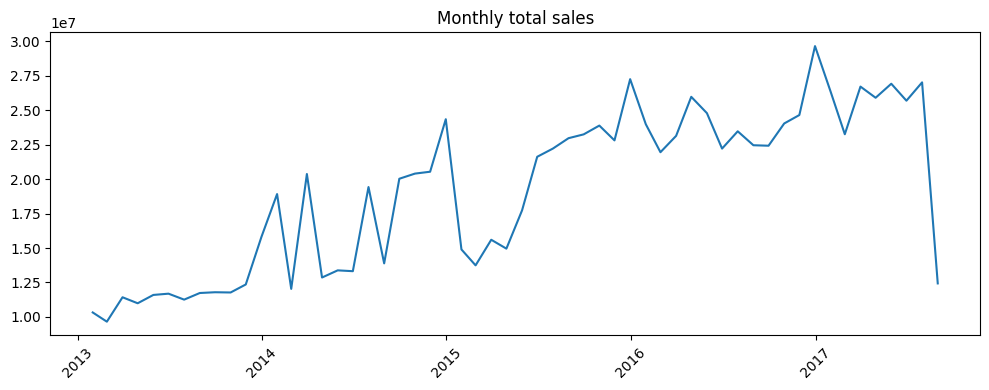


Average sales with vs without promo:
promo_flag
0     158.246681
1    1137.693730
Name: sales, dtype: float64

Week 2 complete: cleaned tables written to DB at C:\Users\nikhs\Downloads\Data Practicum 1\multi-source-sales-forecasting\data\sales_data.db


In [9]:
# WEEK 2 - ETL, CLEANING & INITIAL EDA (writes clean tables to SQLite)
import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import sqlalchemy
from sqlalchemy import text
from pathlib import Path

ROOT = Path.cwd().parent
RAW = ROOT / "data" / "raw"
DB_PATH = ROOT / "data" / "sales_data.db"
engine = sqlalchemy.create_engine(f"sqlite:///{DB_PATH}")

files = {
    "train": "train.csv",
    "stores": "stores.csv",
    "oil": "oil.csv",
    "holidays": "holidays_events.csv",
    "transactions": "transactions.csv"
}

# Step 1: Load raw CSVs into DB
for tbl, fname in files.items():
    path = RAW / fname
    if path.exists():
        print(f"Loading {fname} -> {tbl}")
        df = pd.read_csv(path, low_memory=False)
        df.to_sql(tbl, engine, if_exists="replace", index=False)
    else:
        print(f" Missing raw file: {path}")

# Step 2: Create cleaned DB tables
with engine.begin() as conn:
    conn.execute(text("DROP TABLE IF EXISTS train_clean"))
    conn.execute(text("""
        CREATE TABLE train_clean AS
        SELECT
            CAST(id AS INTEGER) AS id,
            date(date) AS date,
            CAST(store_nbr AS INTEGER) AS store_nbr,
            family,
            CAST(sales AS REAL) AS sales,
            CAST(onpromotion AS INTEGER) AS onpromotion
        FROM train
        WHERE sales IS NOT NULL AND sales >= 0
    """))

    conn.execute(text("DROP TABLE IF EXISTS oil_clean"))
    conn.execute(text("""
        CREATE TABLE oil_clean AS
        SELECT date(date) AS date,
               CAST(dcoilwtico AS REAL) AS oil_price
        FROM oil
    """))

    conn.execute(text("DROP TABLE IF EXISTS holidays_clean"))
    conn.execute(text("""
        CREATE TABLE holidays_clean AS
        SELECT date(date) AS date,
               type,
               locale,
               locale_name,
               description,
               CASE WHEN lower(transferred) IN ('true','1','t') THEN 1 ELSE 0 END AS transferred
        FROM holidays
    """))

    conn.execute(text("DROP TABLE IF EXISTS transactions_clean"))
    conn.execute(text("""
        CREATE TABLE transactions_clean AS
        SELECT date(date) AS date,
               CAST(store_nbr AS INTEGER) AS store_nbr,
               CAST(transactions AS INTEGER) AS transactions
        FROM transactions
        WHERE transactions IS NOT NULL
    """))

    conn.execute(text("DROP TABLE IF EXISTS stores_clean"))
    conn.execute(text("""
        CREATE TABLE stores_clean AS
        SELECT DISTINCT
            CAST(store_nbr AS INTEGER) AS store_nbr,
            city, state, type, CAST(cluster AS INTEGER) AS cluster
        FROM stores
    """))

print("Base clean tables created in DB")

# Step 3: Interpolate oil to daily and save back
oil = pd.read_sql("SELECT * FROM oil_clean", engine, parse_dates=['date'])
oil = oil.set_index('date').asfreq('D')
oil['oil_price'] = oil['oil_price'].interpolate().bfill().ffill()
oil = oil.reset_index()
oil.to_sql("oil_clean", engine, if_exists="replace", index=False)
print("Oil interpolated to daily and saved to DB")

# Step 4: holidays: drop transferred
hol = pd.read_sql("SELECT * FROM holidays_clean", engine, parse_dates=['date'])
hol['transferred'] = hol['transferred'].astype(int)
hol = hol[hol['transferred'] == 0].copy()
hol['type'] = hol['type'].str.strip().str.upper()
hol.to_sql("holidays_clean", engine, if_exists="replace", index=False)
print("Holidays filtered and saved to DB")

# Step 5: add promo flag/count
train = pd.read_sql("SELECT * FROM train_clean", engine, parse_dates=['date'])
train['promo_count'] = train['onpromotion'].fillna(0).astype(int)
train['promo_flag'] = (train['promo_count'] > 0).astype(int)
train.to_sql("train_clean", engine, if_exists="replace", index=False)
print("Train promo fields added and saved to DB")

# Step 6: Quick EDA prints and sample plots (small samples)
print("\nQuick summaries:")
print("Train rows:", len(train))
print("Zero sales ratio:", (train['sales'] == 0).mean())

# Monthly aggregated plot (sample)
monthly_total = train.groupby(pd.Grouper(key='date', freq='M'))['sales'].sum()
plt.figure(figsize=(10,4)); plt.plot(monthly_total.index, monthly_total.values); plt.title("Monthly total sales"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Promo effect
print("\nAverage sales with vs without promo:")
print(train.groupby('promo_flag')['sales'].mean())

print("\nWeek 2 complete: cleaned tables written to DB at", DB_PATH)


In [10]:
# Week 3 — Feature Engineering

import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import text
from pathlib import Path

# Setup paths & DB connection
ROOT = Path.cwd().parent  
DB_PATH = ROOT / "data/sales_data.db"
OUT_DIR = ROOT / "data/processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

engine = sqlalchemy.create_engine(f"sqlite:///{DB_PATH}")

# Aggregate to monthly level
with engine.begin() as conn:
    # Monthly sales
    conn.execute(text("DROP TABLE IF EXISTS monthly_sales"))
    conn.execute(text("""
        CREATE TABLE monthly_sales AS
        SELECT store_nbr, family,
               date(substr(date,1,7)||'-01') as month,
               SUM(sales) as sales
        FROM train_clean
        GROUP BY store_nbr,family,month
    """))
    # Monthly oil
    conn.execute(text("DROP TABLE IF EXISTS monthly_oil"))
    conn.execute(text("""
        CREATE TABLE monthly_oil AS
        SELECT date(substr(date,1,7)||'-01') as month,
               AVG(oil_price) as oil_price
        FROM oil_clean
        GROUP BY month
    """))
    # Monthly holidays
    conn.execute(text("DROP TABLE IF EXISTS monthly_holidays"))
    conn.execute(text("""
        CREATE TABLE monthly_holidays AS
        SELECT date(substr(date,1,7)||'-01') as month,
               COUNT(*) as holiday_count
        FROM holidays_clean
        GROUP BY month
    """))
    # Monthly transactions
    conn.execute(text("DROP TABLE IF EXISTS monthly_transactions"))
    conn.execute(text("""
        CREATE TABLE monthly_transactions AS
        SELECT store_nbr,
               date(substr(date,1,7)||'-01') as month,
               SUM(transactions) as transactions
        FROM transactions_clean
        GROUP BY store_nbr,month
    """))

# Merge into single table 
monthly = pd.read_sql("""
SELECT m.store_nbr,
       m.family,
       m.month,
       m.sales,
       s.city,
       s.state,
       s.type as store_type,
       s.cluster,
       o.oil_price,
       h.holiday_count,
       t.transactions
FROM monthly_sales m
LEFT JOIN stores_clean s ON m.store_nbr = s.store_nbr
LEFT JOIN monthly_oil o ON m.month = o.month
LEFT JOIN monthly_holidays h ON m.month = h.month
LEFT JOIN monthly_transactions t ON m.store_nbr = t.store_nbr AND m.month = t.month
""", engine, parse_dates=['month'])

# Feature engineering
monthly = monthly.sort_values(['store_nbr','family','month'])
monthly['month_of_year'] = monthly['month'].dt.month
monthly['year'] = monthly['month'].dt.year

# Lag features
for lag in [1, 2, 3, 6, 12]:
    monthly[f"sales_lag_{lag}"] = (
        monthly.groupby(['store_nbr','family'])['sales'].shift(lag)
    )

# Rolling averages FIXED
for r in [3, 6]:
    monthly[f"sales_roll_{r}"] = (
        monthly.groupby(['store_nbr','family'])['sales']
        .transform(lambda x: x.shift(1).rolling(r).mean())
    )

# Fill missing values
monthly['oil_price'] = monthly['oil_price'].ffill().bfill()
monthly['holiday_count'] = monthly['holiday_count'].fillna(0)
monthly['transactions'] = monthly['transactions'].fillna(0)

# Save processed dataset 
try:
    OUT_PATH = OUT_DIR / "monthly_sales_features.parquet"
    monthly.to_parquet(OUT_PATH, index=False)
    print(" Saved dataset to Parquet:", OUT_PATH)
except Exception as e:
    OUT_PATH = OUT_DIR / "monthly_sales_features.csv"
    monthly.to_csv(OUT_PATH, index=False)
    print(" Parquet save failed. Saved as CSV instead:", OUT_PATH)
    print("Error:", e)

# ALSO save to DB for downstream steps
monthly.to_sql("monthly_sales_features", engine, if_exists="replace", index=False)
print(" Saved dataset to database table: monthly_sales_features")

# Summary report
print("\n Week 3 complete")
print("Shape:", monthly.shape)
print("Columns:", monthly.columns.tolist())
print("\nMissing values per column:")
print(monthly.isna().sum())


 Saved dataset to Parquet: C:\Users\nikhs\Downloads\Data Practicum 1\multi-source-sales-forecasting\data\processed\monthly_sales_features.parquet
 Saved dataset to database table: monthly_sales_features

 Week 3 complete
Shape: (99792, 20)
Columns: ['store_nbr', 'family', 'month', 'sales', 'city', 'state', 'store_type', 'cluster', 'oil_price', 'holiday_count', 'transactions', 'month_of_year', 'year', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_6', 'sales_lag_12', 'sales_roll_3', 'sales_roll_6']

Missing values per column:
store_nbr            0
family               0
month                0
sales                0
city                 0
state                0
store_type           0
cluster              0
oil_price            0
holiday_count        0
transactions         0
month_of_year        0
year                 0
sales_lag_1       1782
sales_lag_2       3564
sales_lag_3       5346
sales_lag_6      10692
sales_lag_12     21384
sales_roll_3      5346
sales_roll_6     10692


Loaded monthly features: (99792, 20)


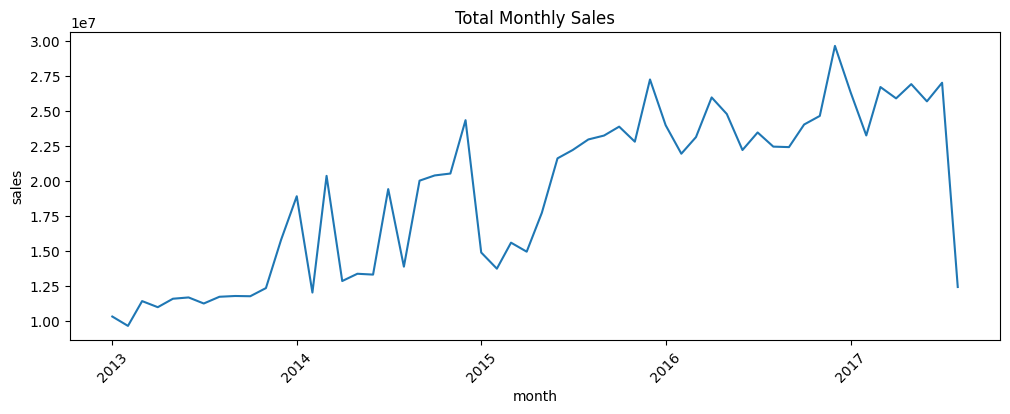

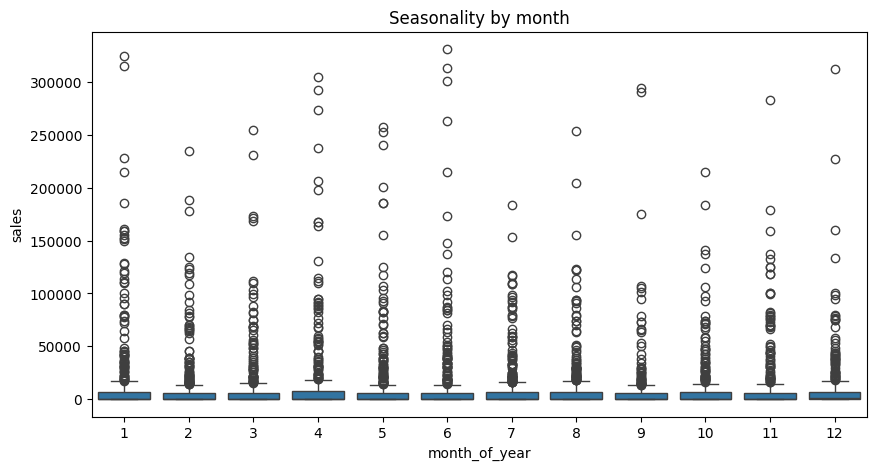

Naive lag-12 RMSE: 10622.998142539267


12:45:47 - cmdstanpy - INFO - Chain [1] start processing


ARIMA forecast (6):
 2017-09-01    103.833940
2017-10-01    110.005342
2017-11-01    102.510198
2017-12-01    119.094221
2018-01-01    127.892682
2018-02-01    114.532410
Freq: MS, Name: predicted_mean, dtype: float64


12:45:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet tail:
            ds          yhat
57 2017-10-01  2.900675e+07
58 2017-11-01  2.913960e+07
59 2017-12-01  3.302716e+07
60 2018-01-01  2.940364e+07
61 2018-02-01  2.648424e+07
Week 4 complete


In [11]:
# WEEK 4 - EDA & Baseline Models
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import sqlalchemy
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

ROOT = Path.cwd().parent
DB_PATH = ROOT / "data" / "sales_data.db"
engine = sqlalchemy.create_engine(f"sqlite:///{DB_PATH}")

monthly = pd.read_sql("SELECT * FROM monthly_sales_features", engine, parse_dates=["month"])
print("Loaded monthly features:", monthly.shape)

# EDA: global trend
agg = monthly.groupby('month')['sales'].sum().reset_index()
plt.figure(figsize=(12,4)); sns.lineplot(data=agg, x='month', y='sales'); plt.title("Total Monthly Sales"); plt.xticks(rotation=45); plt.show()

# Seasonal boxplot
plt.figure(figsize=(10,5)); sns.boxplot(x='month_of_year', y='sales', data=monthly.sample(min(5000,len(monthly)), random_state=42)); plt.title("Seasonality by month"); plt.show()

# Naive baseline (lag-12)
monthly['pred_naive'] = monthly['sales_lag_12']
cutoff = monthly['month'].max() - pd.DateOffset(months=6)
val = monthly[monthly['month'] > cutoff]
rmse = lambda y,yhat: np.sqrt(((y-yhat)**2).mean())
print("Naive lag-12 RMSE:", rmse(val['sales'], val['pred_naive']))

# ARIMA on a sample series (store 1, first family)
sample = monthly[(monthly.store_nbr==1)].copy()
sample = sample[sample['family']==sample['family'].unique()[0]].set_index('month').asfreq('MS')
series = sample['sales'].fillna(0)
model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
res = model.fit(disp=False)
print("ARIMA forecast (6):\n", res.forecast(6))

# Prophet aggregated
agg_sales = monthly.groupby('month')['sales'].sum().reset_index().rename(columns={'month':'ds','sales':'y'})
m = Prophet(yearly_seasonality=True)
m.fit(agg_sales)
future = m.make_future_dataframe(periods=6, freq='MS')
fcst = m.predict(future)
print("Prophet tail:\n", fcst[['ds','yhat']].tail())

# Save baseline metrics to processed folder
pd.DataFrame([{"model":"naive_lag12","rmse":rmse(val['sales'], val['pred_naive'])}]).to_csv(ROOT/"data"/"processed"/"baseline_metrics.csv", index=False)

print("Week 4 complete")


In [12]:
# WEEK 5 - Advanced Models (RandomForest, XGBoost, LSTM) (DB-first)
import pandas as pd, numpy as np
from pathlib import Path
import sqlalchemy
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import joblib
import warnings
warnings.filterwarnings("ignore")

ROOT = Path.cwd().parent
DB_PATH = ROOT / "data" / "sales_data.db"
engine = sqlalchemy.create_engine(f"sqlite:///{DB_PATH}")

monthly = pd.read_sql("SELECT * FROM monthly_sales_features", engine, parse_dates=["month"]).dropna()
print("Loaded monthly features:", monthly.shape)

# Choose features & target
features = [c for c in monthly.columns if ("lag" in c or "roll" in c) or c in ["oil_price","holiday_count","trans_avg","month_of_year","promo_flag_any","promo_count_sum","trans_sum"]]
target = "sales"
X = monthly[features].fillna(0)
y = monthly[target]

# Train/val split (time-ordered)
split = int(len(X)*0.8)
X_train, X_val = X.iloc[:split], X.iloc[split:]
y_train, y_val = y.iloc[:split], y.iloc[split:]

rmse = lambda y,yhat: np.sqrt(mean_squared_error(y,yhat))

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print("RF RMSE:", rmse(y_val, rf_preds))
joblib.dump(rf, ROOT/"models"/"rf_week5.pkl")

# XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
params = {"objective":"reg:squarederror","eta":0.05,"max_depth":6,"subsample":0.8,"colsample_bytree":0.8}
xgb_model = xgb.train(params, dtrain, num_boost_round=300, evals=[(dval,'val')], verbose_eval=False)
xgb_preds = xgb_model.predict(dval)
print("XGB RMSE:", rmse(y_val, xgb_preds))
xgb_model.save_model(str(ROOT/"models"/"xgb_week5.json"))

# LSTM (simple)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_s, X_val_s = X_seq[:split], X_seq[split:]
y_train_s, y_val_s = y_train.values, y_val.values

lstm = models.Sequential([layers.LSTM(64, input_shape=(1, X_scaled.shape[1])), layers.Dense(1)])
lstm.compile(optimizer="adam", loss="mse")
lstm.fit(X_train_s, y_train_s, epochs=5, batch_size=64, verbose=1)
lstm_preds = lstm.predict(X_val_s).flatten()
print("LSTM RMSE:", rmse(y_val_s, lstm_preds))
lstm.save(str(ROOT/"models"/"lstm_week5.keras"))

print("Week 5 complete - models saved to models/")


Loaded monthly features: (78408, 20)
RF RMSE: 11093.347054549455
XGB RMSE: 9905.834118828563
Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 816775808.0000
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 815541568.0000
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 814534144.0000
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - loss: 813593664.0000
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 812681984.0000
491/491 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step
LSTM RMSE: 55322.02461506512
Week 5 complete - models saved to models/


In [13]:
# ============================================
# WEEK 6 - HYPERPARAMETER TUNING (DB-first)
# ============================================

import pandas as pd, numpy as np
import sqlalchemy
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------------
# Load dataset from SQLite
# --------------------------------------------
ROOT = Path.cwd().parent
DB_PATH = ROOT / "data/sales_data.db"
engine = sqlalchemy.create_engine(f"sqlite:///{DB_PATH}")

monthly = pd.read_sql("SELECT * FROM monthly_sales_features", engine, parse_dates=["month"]).dropna()
print("✅ Loaded dataset from DB:", monthly.shape)

# --------------------------------------------
# Features & Target
# --------------------------------------------
features = [
    c for c in monthly.columns 
    if "lag" in c or "roll" in c or c in ["oil_price","holiday_count","month_of_year"]
]
target = "sales"

X = monthly[features]
y = monthly[target]

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

# ============================================
# OPTUNA - Random Forest
# ============================================

def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return rmse(y_val, preds)

print("\n🔎 Tuning Random Forest with Optuna...")
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=20)

print("✅ Best RF Params:", rf_study.best_params)
print("✅ Best RF RMSE:", rf_study.best_value)

best_rf = RandomForestRegressor(**rf_study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

joblib.dump(best_rf, ROOT / "models/best_random_forest.pkl")

# ============================================
# OPTUNA - XGBoost
# ============================================

def xgb_objective(trial):
    params = {
        "objective": "reg:squarederror",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
    }
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    model = xgb.train(params, dtrain, num_boost_round=200, verbose_eval=False)
    preds = model.predict(dval)
    return rmse(y_val, preds)

print("\n🔎 Tuning XGBoost with Optuna...")
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=20)

print("✅ Best XGB Params:", xgb_study.best_params)
print("✅ Best XGB RMSE:", xgb_study.best_value)

# Train best model
best_xgb = xgb.train(xgb_study.best_params, xgb.DMatrix(X, label=y), num_boost_round=200)
best_xgb.save_model(str(ROOT / "models/best_xgboost.json"))

print("\n✅ Week 6 complete - models saved!")


[I 2025-10-19 12:46:28,566] A new study created in memory with name: no-name-363dbede-6f8d-425c-8292-7fc02f1ccf0e


✅ Loaded dataset from DB: (78408, 20)

🔎 Tuning Random Forest with Optuna...


[I 2025-10-19 12:46:57,553] Trial 0 finished with value: 11319.557726942538 and parameters: {'n_estimators': 416, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 11319.557726942538.
[I 2025-10-19 12:47:08,961] Trial 1 finished with value: 12422.26367991258 and parameters: {'n_estimators': 350, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 11319.557726942538.
[I 2025-10-19 12:47:56,269] Trial 2 finished with value: 11095.093409469218 and parameters: {'n_estimators': 486, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 11095.093409469218.
[I 2025-10-19 12:48:08,607] Trial 3 finished with value: 11935.73460737015 and parameters: {'n_estimators': 277, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 2 with value: 11095.093409469218.
[I 2025-10-19 12:48:29,629] Trial 4 finished with value: 11562.44853794452 and parameters: {'n_

✅ Best RF Params: {'n_estimators': 440, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}
✅ Best RF RMSE: 11069.373237242235


[I 2025-10-19 12:55:48,125] A new study created in memory with name: no-name-82d7d8bf-e335-4ee0-9e30-c0c441fe010b



🔎 Tuning XGBoost with Optuna...


[I 2025-10-19 12:55:48,917] Trial 0 finished with value: 10877.912156853185 and parameters: {'max_depth': 10, 'eta': 0.023369045642976625, 'subsample': 0.9828310915796249, 'colsample_bytree': 0.8902859402177001, 'lambda': 2.944658425574995}. Best is trial 0 with value: 10877.912156853185.
[I 2025-10-19 12:55:49,371] Trial 1 finished with value: 10100.723009960293 and parameters: {'max_depth': 8, 'eta': 0.06299647056100473, 'subsample': 0.9922400360819984, 'colsample_bytree': 0.6118763467617252, 'lambda': 0.8710894971744205}. Best is trial 1 with value: 10100.723009960293.
[I 2025-10-19 12:55:49,866] Trial 2 finished with value: 10440.011337546344 and parameters: {'max_depth': 8, 'eta': 0.15539450026214946, 'subsample': 0.9259377677058538, 'colsample_bytree': 0.6129468881103006, 'lambda': 0.15722732769524506}. Best is trial 1 with value: 10100.723009960293.
[I 2025-10-19 12:55:50,181] Trial 3 finished with value: 11541.23444554564 and parameters: {'max_depth': 4, 'eta': 0.05022576134865

✅ Best XGB Params: {'max_depth': 9, 'eta': 0.08229819364624347, 'subsample': 0.9554536714325578, 'colsample_bytree': 0.8882069330398181, 'lambda': 3.6618033990068812}
✅ Best XGB RMSE: 9806.58273785707

✅ Week 6 complete - models saved!


✅ Loaded dataset from DB: (78408, 20)

✅ Week 7 complete - Results saved to: C:\Users\nikhs\Downloads\Data Practicum 1\multi-source-sales-forecasting\data\processed\model_leaderboard.csv
          model          rmse
0  RandomForest  11069.373237
1       XGBoost   3547.174358
2          LSTM  55322.024615
3      Ensemble  20199.895534


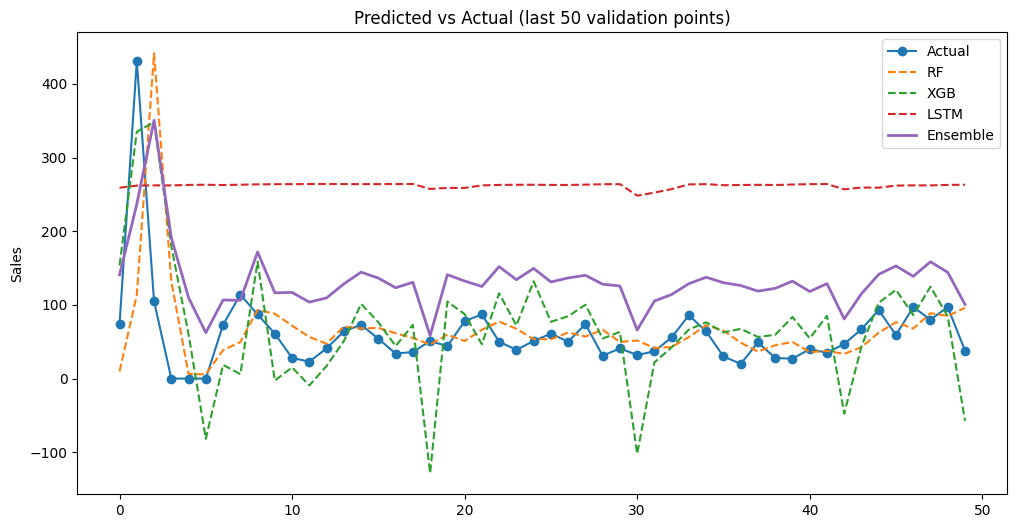

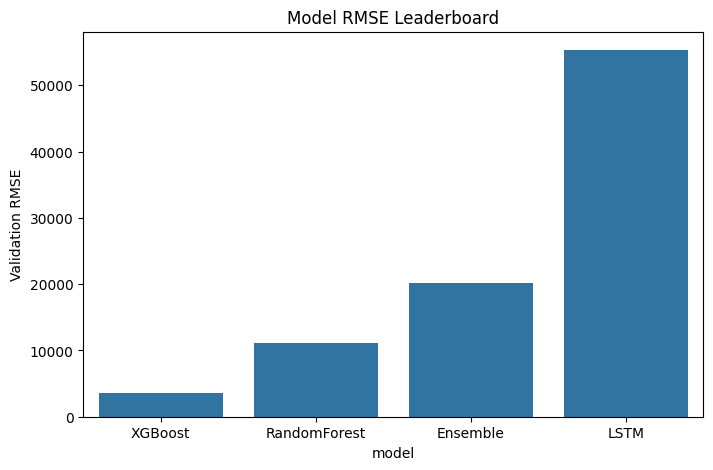

In [14]:
# ============================================
# WEEK 7 - FINAL MODEL COMPARISON & ENSEMBLING (with Plots)
# ============================================

import pandas as pd, numpy as np
import sqlalchemy
from pathlib import Path
from sklearn.metrics import mean_squared_error
import joblib, xgboost as xgb
from tensorflow.keras import models
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------
# Load dataset from SQLite
# --------------------------------------------
ROOT = Path.cwd().parent
DB_PATH = ROOT / "data/sales_data.db"
engine = sqlalchemy.create_engine(f"sqlite:///{DB_PATH}")

monthly = pd.read_sql("SELECT * FROM monthly_sales_features", engine, parse_dates=["month"]).dropna()
print("✅ Loaded dataset from DB:", monthly.shape)

# --------------------------------------------
# Features & Target
# --------------------------------------------
features = [
    c for c in monthly.columns 
    if "lag" in c or "roll" in c or c in ["oil_price","holiday_count","month_of_year"]
]
target = "sales"

X = monthly[features]
y = monthly[target]

# Train/validation split
split = int(len(X) * 0.8)
X_train, X_val = X.iloc[:split], X.iloc[split:]
y_train, y_val = y.iloc[:split], y.iloc[split:]

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

# --------------------------------------------
# Load tuned Random Forest
# --------------------------------------------
rf = joblib.load(ROOT / "models/best_random_forest.pkl")
rf_preds = rf.predict(X_val)
rf_rmse = rmse(y_val, rf_preds)

# --------------------------------------------
# Load tuned XGBoost
# --------------------------------------------
xgb_model = xgb.Booster()
xgb_model.load_model(str(ROOT / "models/best_xgboost.json"))
xgb_preds = xgb_model.predict(xgb.DMatrix(X_val))
xgb_rmse = rmse(y_val, xgb_preds)

# --------------------------------------------
# Load trained LSTM
# --------------------------------------------
lstm = models.load_model(ROOT / "models/lstm_week5.keras")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_val_s = X_scaled[split:].reshape((X_val.shape[0], 1, X_val.shape[1]))
lstm_preds = lstm.predict(X_val_s, verbose=0).flatten()
lstm_rmse = rmse(y_val.values, lstm_preds)

# --------------------------------------------
# Simple Ensemble
# --------------------------------------------
ensemble_preds = (rf_preds + xgb_preds + lstm_preds) / 3
ensemble_rmse = rmse(y_val, ensemble_preds)

# --------------------------------------------
# Save leaderboard
# --------------------------------------------
results = pd.DataFrame([
    {"model": "RandomForest", "rmse": rf_rmse},
    {"model": "XGBoost", "rmse": xgb_rmse},
    {"model": "LSTM", "rmse": lstm_rmse},
    {"model": "Ensemble", "rmse": ensemble_rmse},
])

LEADERBOARD_PATH = ROOT / "data/processed/model_leaderboard.csv"
results.to_csv(LEADERBOARD_PATH, index=False)
print("\n✅ Week 7 complete - Results saved to:", LEADERBOARD_PATH)
print(results)

# --------------------------------------------
# PLOTS
# --------------------------------------------

# 1. Predicted vs Actual (last 50 points for clarity)
plt.figure(figsize=(12,6))
plt.plot(y_val.values[-50:], label="Actual", marker="o")
plt.plot(rf_preds[-50:], label="RF", linestyle="--")
plt.plot(xgb_preds[-50:], label="XGB", linestyle="--")
plt.plot(lstm_preds[-50:], label="LSTM", linestyle="--")
plt.plot(ensemble_preds[-50:], label="Ensemble", linewidth=2)
plt.legend()
plt.title("Predicted vs Actual (last 50 validation points)")
plt.ylabel("Sales")
plt.show()

# 2. RMSE Leaderboard (bar chart)
plt.figure(figsize=(8,5))
sns.barplot(x="model", y="rmse", data=results.sort_values("rmse"))
plt.title("Model RMSE Leaderboard")
plt.ylabel("Validation RMSE")
plt.show()
